In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(device)

cuda:0


# Initialize for CPU & GPU

In [3]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal


Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.3.1-py3-none-any.whl


# Import

In [4]:
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU, LeakyReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import autograd
from torch_geometric.nn.models import InnerProductDecoder
from torch_geometric.utils import to_dense_adj

from sklearn.model_selection import train_test_split

# DataLoader

In [5]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]
Additional_Attr = List[np.ndarray]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
    ):
        
        self.edge_flag = torch.LongTensor(edge_flag)
        self.edge_index = torch.LongTensor(edge_index).T
        self.raw_edge_attr = edge_attr
        self.node_flag = torch.LongTensor(node_flag)
        self.node_index = torch.LongTensor(node_index).to(device)
        self.raw_node_attr = node_attr 
        self.ts_list = ts_list
        
        self.node_attr = None
        self.node_attr_extend = None
        self.edge_flag_extend = None
        self.edge_index_extend = None
        
        
        self._set_snapshot_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.edge_flag)
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_edge_attr)).to(device)
        
    
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_node_attr)).to(device)
        self.node_attr = self.node_attr_encoded.index_select(dim=0,index=signal.node_index).to(device)
        
    def extend_node_attr(self):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        node_index = self.node_index
        node_attr = self.node_attr
        node_flag = self.node_flag[:-1]
        
        edge_index = self.edge_index
        edge_attr = self.edge_attr_encoded
        edge_flag = self.edge_flag[:-1]
        
        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)

        base = 0
        new_node_attr = []
        new_edge_flag = []
        new_edge_index = []
        
        for i_snapshot in range(signal.snapshot_count):
            _node_index = node_index_split[i_snapshot]
            _node_attr = node_attr_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            _edge_attr = edge_attr_split[i_snapshot]

            if _edge_index.shape[1] != _edge_attr.shape[0]:
                print(i_snapshot, edge_index.shape, _edge_attr.shape)
                raise
            if _edge_index.shape[1] > 0:
                index_dict = {}
                for i_edge in range(_edge_index.shape[1]):
                    index_tuple = tuple(_edge_index[:,i_edge].tolist())
                    if index_tuple in index_dict:
                        index_dict[index_tuple] += [i_edge]
                    else:
                        index_dict[index_tuple] = [i_edge]

                _new_edge_index = []
                _new_edge_attr = []
                for key in index_dict.keys():
                    _new_edge_index.append(key)
        #                     print(index_dict[key])
                    _new_edge_attr.append(torch.sum(_edge_attr.index_select(0, torch.LongTensor(index_dict[key]).to(device)),dim=0).unsqueeze(0))

                _new_edge_index = torch.LongTensor(_new_edge_index).T.to(device)
                _new_edge_attr = torch.cat(_new_edge_attr,dim=0).to(device)
                
                base += _new_edge_index.shape[1]
                new_edge_index.append(_new_edge_index)

                _source_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
                _target_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
                _source_attr.index_add_(0, _new_edge_index[0], _new_edge_attr)
                _target_attr.index_add_(0, _new_edge_index[1], _new_edge_attr)
                
                new_node_attr.append(torch.cat([_node_attr,_source_attr,_target_attr], dim=1)) 

            new_edge_flag.append(base)
        
        
        self.node_attr_extend = torch.cat(new_node_attr, dim=0).to(device)
        self.edge_flag_extend = new_edge_flag
        self.edge_index_extend = torch.cat(new_edge_index,dim=1).to(device)
        
    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    # def _get_edge_weight(self, time_index: int):
    #     if self.edge_weights[time_index] is None:
    #         return self.edge_weights[time_index]
    #     else:
    #         return torch.FloatTensor(self.edge_weights[time_index])

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp = _timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp']
        )
        return dataset

In [6]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
annotation = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        raise

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    annotation.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, annotation_train, annotation_test = train_test_split(signals, annotation, test_size=0.2, random_state=1)
signals_train, signals_val, annotation_train, annotation_val = train_test_split(signals_train, annotation_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [7]:
_interval = 60
_overlap = 30

node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.raw_node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.raw_edge_attr for sample in signals_train]))

for i_signal, signal in enumerate(signals_train):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    

adj_list_train = []
for signal in signals_train:
    edge_index = signal.edge_index_extend
    edge_flag = signal.edge_flag_extend[:-1]
    edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
    
    adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
    adj_list_train.append(adj_list)
    
y_train = []
for signal, annotation in zip(signals_train, annotation_train): 
    ts_list = signal.ts_list
    y = torch.zeros(signal.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_train.append(y)


    
for i_signal, signal in enumerate(signals_val):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()

adj_list_val = []
for signal in signals_val:
    edge_index = signal.edge_index_extend
    edge_flag = signal.edge_flag_extend[:-1]
    edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
    
    adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
    adj_list_val.append(adj_list)

y_val = []
for signal, annotation in zip(signals_val, annotation_val): 
    ts_list = signal.ts_list
    y = torch.zeros(signal.snapshot_count, dtype=torch.long)
    for i_ts, ts in enumerate(ts_list):
        if ts < float(annotation[1]) and float(annotation[1]) <= ts+_interval: 
            y[i_ts] = 1
    y_val.append(y)

    
IN_CHANNELS = signals_train[0].node_attr_extend.shape[1]
# EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

In [8]:
signal = signals_train[0]

node_index = signal.node_index
node_attr = signal.node_attr_extend
node_flag = signal.node_flag[:-1]

edge_index = signal.edge_index_extend
edge_flag = signal.edge_flag_extend[:-1]

node_index_split = torch.tensor_split(node_index, node_flag)
node_attr_split = torch.tensor_split(node_attr, node_flag)
edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)

print(node_attr.shape)
print(node_index.shape)
print(edge_index.shape)

torch.Size([2465, 121])
torch.Size([2465])
torch.Size([2, 7724])


In [9]:
from torch_geometric.data import Batch
from torch_geometric.data.data import Data

data_list = []
for i_snapshot in range(signal.snapshot_count):
    _node_attr = node_attr_split[i_snapshot]
    _edge_index = edge_index_split[i_snapshot]
    
    _data = Data(x=_node_attr,edge_index=_edge_index)
#     print(_data.edge_index)
    data_list.append(_data)
    
batch = Batch().from_data_list(data_list)
batch._inc_dict 

defaultdict(dict,
            {'x': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
             'edge_index': tensor([   0,    4,    8,  152,  229,  344,  423,  498,  570,  642,  707,  775,
                      833,  922,  987, 1055, 1127, 1208, 1287, 1369, 1434, 1506, 1588, 1702,
                     1769, 1855, 1920, 1981, 2046, 2125, 2196, 2264, 2328, 2418])})

# Model

In [29]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        embed_layers,  
        decide_layers,
    ):
        super(TGAE, self).__init__()
        
        # Encoder Embeding
        layers = []
        pre_h_num = in_channels
        for h_num in embed_layers[:-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.embed_net = Seq(*layers)
        
        # Graph Conv
        
        self.conv1 = GCNConv(embed_layers[-1], embed_layers[-1]*2)
        self.conv2 = GCNConv(embed_layers[-1]*2, embed_layers[-1]*2)
        self.conv3 = GCNConv(embed_layers[-1]*2, embed_layers[-1])
        
        # GRU Unit
        

#         layers = []
#         pre_h_num = embed_layers[-1]
#         for h_num in decide_layers:
#             layers.append(torch.nn.Dropout(p=0.2))
#             layers.append(Lin(pre_h_num,h_num))
#             layers.append(LeakyReLU())
#             pre_h_num = h_num
#         layers.append(Lin(pre_h_num,out_channels))
#         layers.append(torch.nn.Sigmoid())
#         self.decide_net = Seq(*layers)
        
        # Decoder
        
        self.decoder = InnerProductDecoder()
        

    def forward(self, x , edge_index):
        # Encoder
        out = self.embed_net(x)
        
        out = self.conv1(out, edge_index).relu()
        out = self.conv2(out, edge_index).relu()
        out = self.conv3(out, edge_index)
        
#         out = self.decide_net(out)

        return out
    

# Training

In [30]:
# model = torch.load(
#     "/kaggle/input/tgae-model-saved/TGAE_NNConv_InnerProductDecoder_50_12.3665_12.5501.model",
#     map_location=torch.device(device)
# )

In [31]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=64, 
    embed_layers=[128,256,512,256],
    decide_layers=[512,256,128],
)

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-2)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (embed_net): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=121, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=256, bias=True)
  )
  (conv1): GCNConv(256, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 256)
  (decoder): InnerProductDecoder()
)


## Train Loop

In [32]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device, adj_list):
    model.train()
    
    node_index = signal.node_index
    node_attr = signal.node_attr_extend
    node_flag = signal.node_flag[:-1]

    edge_index = signal.edge_index_extend
    edge_flag = signal.edge_flag_extend[:-1]

    node_index_split = torch.tensor_split(node_index, node_flag)
    node_attr_split = torch.tensor_split(node_attr, node_flag)
    edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
    
    data_list = []
    for i_snapshot in range(signal.snapshot_count):
        _node_attr = node_attr_split[i_snapshot]
        _edge_index = edge_index_split[i_snapshot]

        _data = Data(x=_node_attr,edge_index=_edge_index)
        data_list.append(_data)

    batch = Batch().from_data_list(data_list)
    
    outs = model(batch.x, batch.edge_index)
    out_split = torch.tensor_split(outs, node_flag)
    
    total_loss = 0
    snapshot_losses = []
    for out, adj in zip(out_split,adj_list):
        recon_adj = model.decoder.forward_all(out)
        loss = loss_f(recon_adj, adj)
#         print(recon_adj,adj)
        total_loss += loss
        snapshot_losses.append(loss.detach().cpu().numpy())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    return snapshot_losses

## Test Loop

In [33]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device, adj_list):
    with torch.no_grad():
        node_index = signal.node_index
        node_attr = signal.node_attr_extend
        node_flag = signal.node_flag[:-1]

        edge_index = signal.edge_index_extend
        edge_flag = signal.edge_flag_extend[:-1]

        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)

        data_list = []
        for i_snapshot in range(signal.snapshot_count):
            _node_attr = node_attr_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]

            _data = Data(x=_node_attr,edge_index=_edge_index)
            data_list.append(_data)

        batch = Batch().from_data_list(data_list)

        outs = model(batch.x, batch.edge_index)
        out_split = torch.tensor_split(outs, node_flag)

        snapshot_losses = []
        for out, adj in zip(out_split,adj_list):
            recon_adj = model.decoder.forward_all(out)
            loss = loss_f(recon_adj, adj)

            snapshot_losses.append(loss.detach().cpu().numpy())
    
    return snapshot_losses

In [34]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    global GLOBAL_EPOCH
    
    history_train = []
    history_val = []

    for i_epoch in range(1,num_epoch+1):
        train_losses = []
        _start = time.time()
        for signal,adj_list in zip(signals_train, adj_list_train):
            snapshot_losses = train_loop(signal, model, loss_f, optimizer, device, adj_list)
#             print(np.mean(train_loss))
            train_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            
        
        if i_epoch % 50 == 0:
            val_losses = []
            for signal,adj_list in zip(signals_val, adj_list_val):
                snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, adj_list)
#                 print(np.mean(val_loss))
                val_losses.append(np.mean([np.mean(loss) for loss in snapshot_losses]))
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f} val loss {np.mean(val_losses):.4f}")
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
            if i_epoch % 10 == 0:
                print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f}")
    GLOBAL_EPOCH += num_epoch
    return (history_train,history_val)

In [35]:
history_train_list = []
history_val_list = []

10/500: cost 0.8400s train loss 13.5747
20/500: cost 0.8452s train loss 13.5747
30/500: cost 0.8605s train loss 13.5747
40/500: cost 0.9010s train loss 13.5747
50/500: cost 0.9795s train loss 13.5747 val loss 13.7777
60/500: cost 1.1939s train loss 13.5747
70/500: cost 0.8269s train loss 13.5747
80/500: cost 0.8020s train loss 13.5747
90/500: cost 0.8274s train loss 13.5747
100/500: cost 0.9528s train loss 13.5747 val loss 13.7777
110/500: cost 0.8331s train loss 13.5747
120/500: cost 0.8310s train loss 13.5747
130/500: cost 0.8120s train loss 13.5747
140/500: cost 0.8297s train loss 13.5747
150/500: cost 0.9762s train loss 13.5747 val loss 13.7777
160/500: cost 0.8275s train loss 13.5747
170/500: cost 0.8924s train loss 13.5747
180/500: cost 0.8295s train loss 13.5747
190/500: cost 0.8497s train loss 13.5747
200/500: cost 0.9661s train loss 13.5747 val loss 13.7777
210/500: cost 0.8843s train loss 13.5747
220/500: cost 0.8241s train loss 13.5747
230/500: cost 0.8288s train loss 13.574

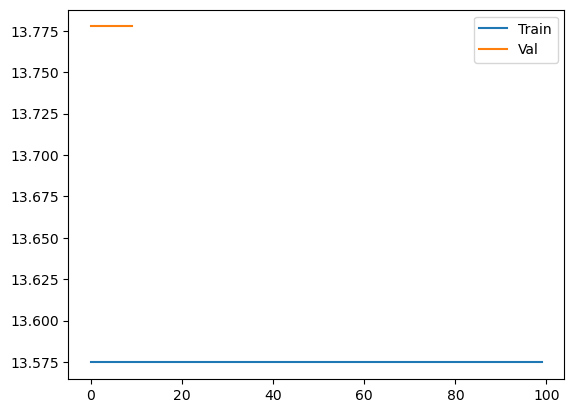

In [36]:
history_train, history_val = train_function(500)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

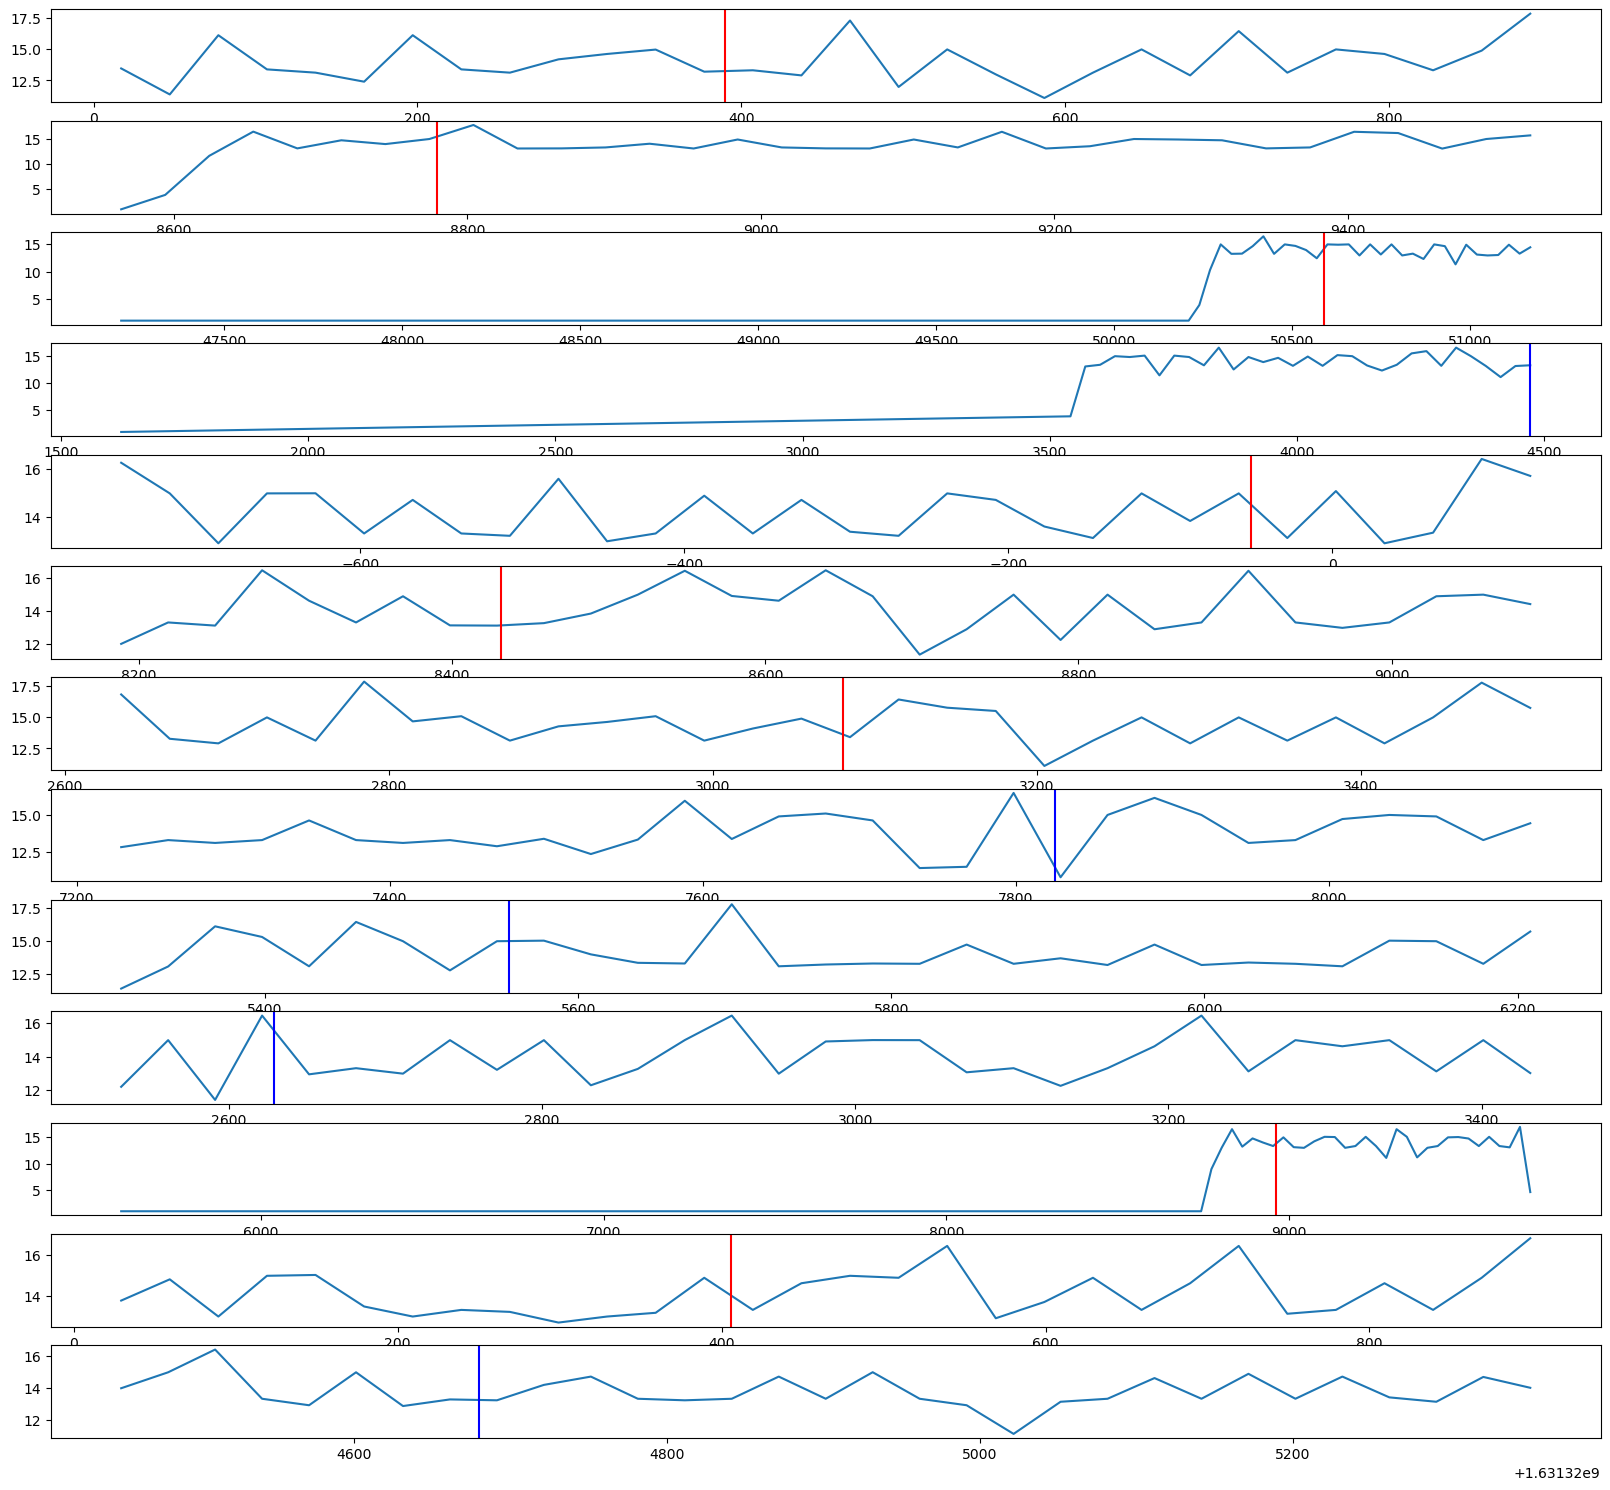

In [37]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, adj_list, annotation) in enumerate(zip(signals_val,adj_list_val, annotation_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, adj_list)
#                 print(np.mean(val_loss))
#     val_losses.append(np.mean(snapshot_losses))
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,snapshot_losses)
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])
# plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [ ]:
torch.save(model,f"TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

# Evaluation

In [ ]:
snapshot_losses_list = []
for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
    snapshot_losses_list.append(snapshot_losses)

In [ ]:
for snapshot_losses, y in zip(snapshot_losses_list,y_val):
#     print(snapshot_losses)
    print([(i_snapshot, len(loss),int(label)) for i_snapshot, (loss, label) in enumerate(zip(snapshot_losses, y))])
    loss_list = []
    for losses in snapshot_losses:
        loss_list += list(losses)
    counts, edges, bars = plt.hist(loss_list)
    plt.bar_label(bars)
    plt.show()
    break
    

In [ ]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][1])
plt.bar_label(bars)
plt.show()

In [ ]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][11])
plt.bar_label(bars)
plt.show()

In [ ]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [ ]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True, record_shapes=True) as prof:
#         history_train, history_val = train_function(1)
#         history_train_list += history_train
#         history_val_list += history_val
#         plt.plot(history_train_list[1::5],label="Train")
#         plt.plot(history_val_list,label="Val")
#         plt.legend()
# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [ ]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [ ]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,snapshot_losses[:-1])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig('val_res.png')

In [ ]:
# torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [ ]:
# history_train, history_val = train_function(100)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [ ]:
# states_encoder_val = []
# states_decoder_val = []
# for num_node in nums_node_val:
#     states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
#     states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

# fig = plt.figure(figsize=(20,20))    
# for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
#     val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#     # print(np.mean(val_loss))
#     ts_list = [snapshot.timestamp for snapshot in sample]
#     plt.subplot(len(X_val)+1,1,i_sample+1)
#     plt.plot(ts_list,val_loss)
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()